# Thevenin Model Cycling

This notebook demonstrates how to use the Thevenin model to simulate a variety of cycling experiments. The Thevenin model is based on PyBaMM implementation of the Thevenin model.

There are a handful of cycling protocols that are implemented in the `sox.battery.protocol` module. These protocols are used to simulate the cycling experiments. The protocols are: 

1. `cc_charge_cv_rest` (CC charge - CV hold - rest)
2. `cc_discharge_rest` (CC discharge - rest)
3. `charge_discharge_cycling` (combination of 1+2 with multiple cycles)
4. `single_pulse` (CC charge or discharge pulse - rest)
5. `single_pulse_train` (a train of CC pulses with a single C rate - rest)
6. `multi_pulse_train` (a train of CC pulses with multiple C rates - rest)
7. `dst_schedule` (dynamic stress test schedule)

In [1]:
import matplotlib.pyplot as plt

from sox.battery import Thevenin, default_thevenin_inputs
import sox.battery.protocol as protocol
from sox.utils import quick_plot

In [7]:
# change default initial soc
default_thevenin_inputs.initial_soc = 0.5

battery = Thevenin(default_thevenin_inputs)

In [12]:
experiments = [
    # constant current then constant voltage charge, then rest
    protocol.cc_charge_cv_rest(c_rate=2.0, cv_hold_c_rate_limit=1 / 6, rest_time_h=0.1),
    # constant current discharge, then rest
    protocol.cc_discharge_rest(),
    # constant current charge and discharge cycling
    protocol.charge_discharge_cycling(direction="charge", number_of_cycles=3),
    # constant current discharge pulse, then rest
    protocol.single_pulse(direction="discharge", c_rate=2.0, pulse_time_sec=60, pulse_rest_time_sec=120),
    # one type of constant current discharge pulses back-to-back, with rest in between
    protocol.single_pulse_train(direction="discharge", number_of_pulses=15),
    # two types of constant current discharge pulses back-to-back, with rest in between
    protocol.multi_pulse_train(
        direction=["discharge", "discharge"],
        c_rate=[1.0, 0.2],
        pulse_time_sec=[60, 600],
        pulse_rest_time_sec=[600, 600],
        number_of_pulses=9,
    ),
    # three types of constant current charge and discharge pulses back-to-back, with rest in between
    protocol.multi_pulse_train(
        direction=["discharge", "charge", "discharge"],
        c_rate=[1.0, 1.0, 0.2],
        pulse_time_sec=[60, 60, 600],
        pulse_rest_time_sec=[600, 600, 600],
        number_of_pulses=10,
    ),
    # DST (dynamic stress test) protocol
    protocol.dst_schedule(
        peak_power=3.8 * (6 * 10),
        number_of_cycles=5,
        sampling_time_s=1,
    ),
]

# simulates the experiments
solutions = [battery.solve(e) for e in experiments]

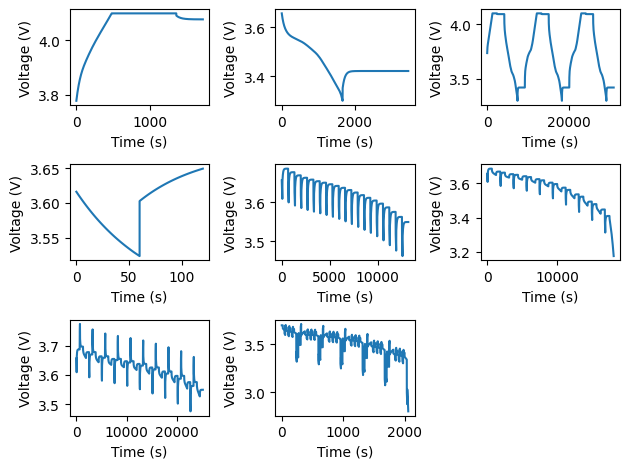

In [9]:
# plots the results

plt.figure()
for i, solution in enumerate(solutions):
    plt.subplot(3, 3, i + 1)
    plt.plot(solution.time, solution.voltage)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
plt.tight_layout()
plt.show()

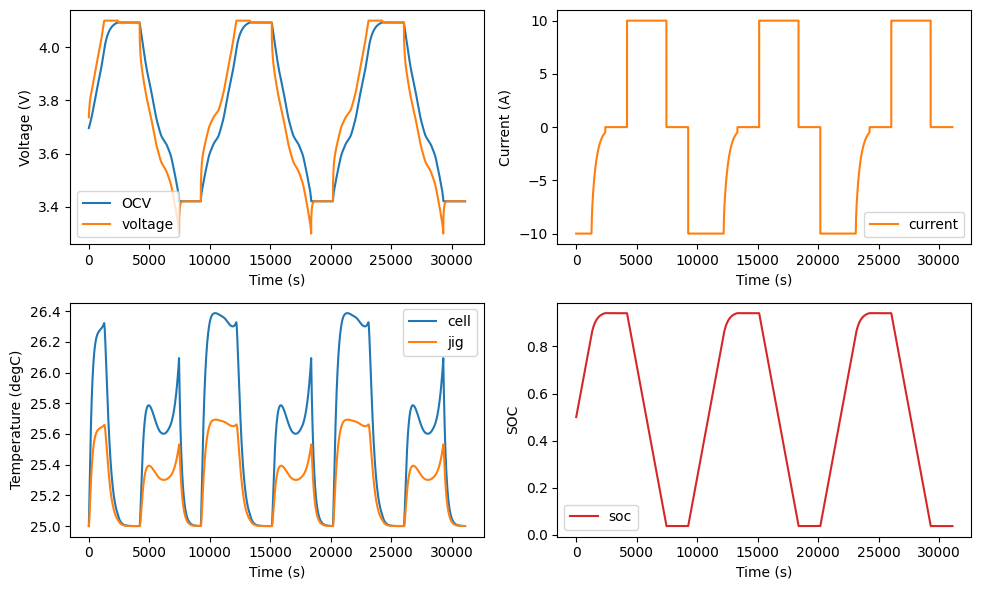

In [14]:
sol = solutions[2]

quick_plot(
    time=sol.time,
    data=[[sol.ocv, sol.voltage], sol.current, [sol.cell_temperature, sol.jig_temperature], sol.soc],
    legend=[["OCV", "voltage"], "current", ["cell", "jig"], "soc"],
    x_label="Time (s)",
    y_label=["Voltage (V)", "Current (A)", "Temperature (degC)", "SOC"],
)